In [1]:
import os
import cPickle
import numpy as np
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import hamming_loss, make_scorer, classification_report
import matplotlib.pyplot as plt
import nltk.data
from nltk.corpus import stopwords

%matplotlib inline
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Windows\ServiceProfile
[nltk_data]     s\LocalService\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
def load_part(file_name):
    with open(file_name, 'rb') as handle:
        return cPickle.load(handle)

In [3]:
# extract from the IMDB data with only 'genres' and 'plot'
imdb_file_name = 'data/cast.pickle'
# full TMDB data
tmdb_file_name = 'data/tmdb_info.pickle'

In [4]:
columns = [
    'director',
    'cast', 
    'casting director', 
    'miscellaneous crew', 
    'original music', 
    'producer', 
    'cinematographer',
    'costume designer',
    'art direction']

In [5]:
# load the IMDB extract
imdb_dict = load_part(imdb_file_name)

In [6]:
# load TMDB 
tmdb_dict = load_part(tmdb_file_name)

Prepare the labels

In [16]:
# array of list of genres for every movie
labels = np.array([d['genres'] for d in imdb_dict.values() if 'genres' in d])

In [17]:
# create the labels vector
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(labels)
print 'label matrix shape:', y.shape

label matrix shape: (47538L, 28L)


In [18]:
# number of movies for every genre
label_df = pd.DataFrame(mlb.fit_transform(labels))
label_df.columns = mlb.classes_
label_number_df = pd.DataFrame({'cnt' : label_df.sum(axis = 0)})
label_number_df

,cnt
Action,5050
Adult,310
Adventure,3261
Animation,3027
Biography,1535
Comedy,13573
Crime,4331
Documentary,5883
Drama,19759
Family,3274


Limit the number of genres.

In [19]:
# only leave generes mentioned in 2000 movies or more
cutoff = 2000
major_genres = set(label_number_df[label_number_df['cnt']  > cutoff].index)
major_genres

{u'Action',
 u'Adventure',
 u'Animation',
 u'Comedy',
 u'Crime',
 u'Documentary',
 u'Drama',
 u'Family',
 u'Fantasy',
 u'Horror',
 u'Mystery',
 u'Romance',
 u'Sci-Fi',
 u'Short',
 u'Thriller'}

In [20]:
# find labels only for the major genres
labels = np.array(
    [major_genres.intersection(d['genres']) for d in imdb_dict.values() if 'genres' in d])

In [21]:
# create the labels vector with only major genres
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(labels)
print 'label matrix shape:', y.shape

label matrix shape: (47538L, 15L)


Prepare the features.  
Here we also add 'cast' and 'crew' from TMDB movies

In [24]:
# combine all names separated by '|'
features = []
for tmdb_id, imdb_movie in imdb_dict.iteritems():
    if 'genres' not in imdb_movie:
        continue
    l = []
    for c in columns:
        if(c in imdb_movie):
            l = l + [ c['name'].encode('utf-8') for c in imdb_movie[c]]
    # add crew and cast from TMDB
    if(tmdb_id in tmdb_dict):
        tmdb_movie = tmdb_dict[tmdb_id].__dict__
        if('crew' in tmdb_movie):
            l = l + [c['name'].encode('utf-8') for c in tmdb_movie['crew']]
        if('cast' in tmdb_movie):
            l = l + [c['name'].encode('utf-8') for c in tmdb_movie['cast']]
    # remove duplicates before joiniing
    features.append('|'.join(set(l)))
print 'Extracted features for ', len(features), ' movies'

Extracted features for  47538  movies


In [25]:
# split into test / train data
F_train, F_test, y_train, y_test = train_test_split(features, y, test_size=0.25, random_state = 442)

Convert a collection of text documents to a matrix of token counts

In [26]:
# it is just a trick to use the CountVectorizer to assign npeople to movies
vectorizer = CountVectorizer( 
    max_df = 0.99,
    min_df = 0.0001,
    stop_words = stopwords.words("english"), 
    tokenizer = lambda x: x.split('|'),
    dtype = np.float32 )
X_train = vectorizer.fit_transform(F_train)
X_test = vectorizer.transform(F_test)

The goal of using tf-idf instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus.

In [27]:
print 'Train label matrix shape:', y_train.shape
print 'Train predictor matrix shape:', X_train.shape
print 'Test label matrix shape:', y_test.shape
print 'Test predictor matrix shape:', X_test.shape

Train label matrix shape: (35653L, 15L)
Train predictor matrix shape: (35653, 76205)
Test label matrix shape: (11885L, 15L)
Test predictor matrix shape: (11885, 76205)


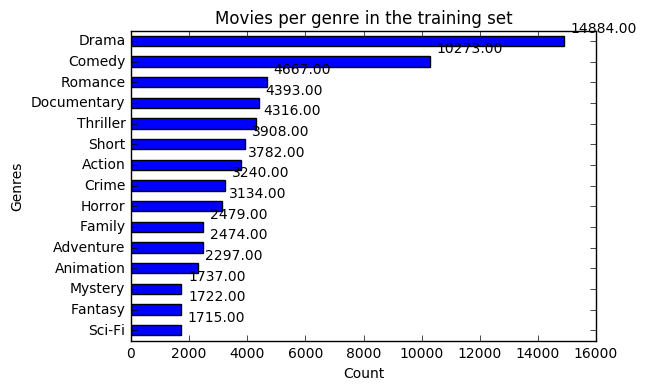

In [28]:
label_df = pd.DataFrame(y_train)
label_df.columns = mlb.classes_
label_number_df = pd.DataFrame({'cnt' : label_df.sum(axis = 0)})
ax = label_number_df.sort_values('cnt')['cnt'].plot(kind="barh", title = 'Movies per genre in the training set')
for p in ax.patches:
    ax.annotate(
        "%.2f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()), xytext=(5, 10), textcoords='offset points')
plt.xlabel('Count')
plt.ylabel('Genres')

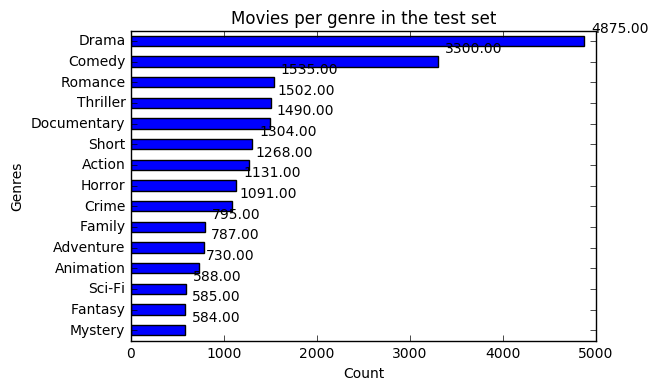

In [29]:
label_df = pd.DataFrame(y_test)
label_df.columns = mlb.classes_
label_number_df = pd.DataFrame({'cnt' : label_df.sum(axis = 0)})
ax = label_number_df.sort_values('cnt')['cnt'].plot(kind="barh", title = 'Movies per genre in the test set')
for p in ax.patches:
    ax.annotate(
        "%.2f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()), xytext=(5, 10), textcoords='offset points')
plt.xlabel('Count')
plt.ylabel('Genres')

The Hamming loss is the fraction of labels that are incorrectly predicted.

In [30]:
param_grid = {
    'estimator__loss': ('hinge', 'log', 'perceptron', 'modified_huber'),
    'estimator__alpha' : np.linspace(1e-04, 1e-06, 50),
    'estimator__penalty' : ('l1', 'l2', 'elasticnet')}

model = OneVsRestClassifier(SGDClassifier(random_state = 761))

model_tunning = GridSearchCV(
    model, 
    param_grid = param_grid, 
    scoring = make_scorer(hamming_loss, greater_is_better = False), 
    n_jobs = -1, 
    verbose = 10)

model_tunning.fit(X_train, y_train)

Fitting 3 folds for each of 600 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   39.9s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   51.1s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:  2.6min
[Paralle

GridSearchCV(cv=None, error_score='raise',
       estimator=OneVsRestClassifier(estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=761, shuffle=True,
       verbose=0, warm_start=False),
          n_jobs=1),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'estimator__alpha': array([  1.00000e-04,   9.79796e-05,   9.59592e-05,   9.39388e-05,
         9.19184e-05,   8.98980e-05,   8.78776e-05,   8.58571e-05,
         8.38367e-05,   8.18163e-05,   7.97959e-05,   7.77755e-05,
         7.57551e-05,   7.37347e-05,   7.17143e-05,   6.96939e-05,
...y': ('l1', 'l2', 'elasticnet'), 'estimator__loss': ('hinge', 'log', 'perceptron', 'modified_huber')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(hamming_loss, greater_is_better=False),
  

In [31]:
model_tunning.best_params_

{'estimator__alpha': 5.9591836734693881e-05,
 'estimator__loss': 'log',
 'estimator__penalty': 'l2'}

Classification quility on the training set

In [32]:
print classification_report(y_train, model_tunning.predict(X_train), target_names = mlb.classes_)

             precision    recall  f1-score   support

     Action       1.00      0.76      0.86      3782
  Adventure       1.00      0.68      0.81      2474
  Animation       0.99      0.59      0.74      2297
     Comedy       1.00      0.80      0.89     10273
      Crime       1.00      0.74      0.85      3240
Documentary       0.99      0.41      0.57      4393
      Drama       1.00      0.85      0.92     14884
     Family       0.98      0.67      0.79      2479
    Fantasy       1.00      0.56      0.71      1722
     Horror       1.00      0.54      0.70      3134
    Mystery       1.00      0.64      0.78      1737
    Romance       1.00      0.73      0.85      4667
     Sci-Fi       1.00      0.61      0.76      1715
      Short       0.98      0.37      0.54      3908
   Thriller       1.00      0.71      0.83      4316

avg / total       1.00      0.70      0.81     65021



Classification quility on the test set

In [33]:
print classification_report(y_test, model_tunning.predict(X_test), target_names = mlb.classes_)

             precision    recall  f1-score   support

     Action       0.72      0.22      0.33      1268
  Adventure       0.65      0.10      0.17       787
  Animation       0.98      0.44      0.61       730
     Comedy       0.75      0.37      0.50      3300
      Crime       0.54      0.08      0.13      1091
Documentary       0.89      0.19      0.31      1490
      Drama       0.68      0.47      0.56      4875
     Family       0.85      0.24      0.37       795
    Fantasy       0.69      0.05      0.09       585
     Horror       0.67      0.10      0.17      1131
    Mystery       0.54      0.03      0.06       584
    Romance       0.47      0.10      0.17      1535
     Sci-Fi       0.70      0.07      0.13       588
      Short       0.95      0.25      0.40      1304
   Thriller       0.60      0.11      0.18      1502

avg / total       0.71      0.26      0.36     21565



In [34]:
model_dict = {}
model_dict['model'] = model_tunning
model_dict['labels'] = labels
model_dict['features'] = features
model_dict['X_train'] = X_train
model_dict['y_train'] = y_train
model_dict['X_test'] = X_test
model_dict['y_test'] = y_test
model_dict['label_names'] = mlb.classes_

with open('models/cast_model.pickle', 'wb') as handle:
    cPickle.dump(model_dict, handle, protocol = cPickle.HIGHEST_PROTOCOL)

In [35]:
d = load_part('models/cast_model.pickle')

In [37]:
print classification_report(d['y_test'], d['model'].predict(d['X_test']), target_names = d['label_names'])

             precision    recall  f1-score   support

     Action       0.72      0.22      0.33      1268
  Adventure       0.65      0.10      0.17       787
  Animation       0.98      0.44      0.61       730
     Comedy       0.75      0.37      0.50      3300
      Crime       0.54      0.08      0.13      1091
Documentary       0.89      0.19      0.31      1490
      Drama       0.68      0.47      0.56      4875
     Family       0.85      0.24      0.37       795
    Fantasy       0.69      0.05      0.09       585
     Horror       0.67      0.10      0.17      1131
    Mystery       0.54      0.03      0.06       584
    Romance       0.47      0.10      0.17      1535
     Sci-Fi       0.70      0.07      0.13       588
      Short       0.95      0.25      0.40      1304
   Thriller       0.60      0.11      0.18      1502

avg / total       0.71      0.26      0.36     21565

